In [1]:
from typing import List, Tuple

import gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from models import init_weights, MLP
from utils import load_config, plot_reward

training_config = load_config("training")
vpg_config = load_config("vpg")

SEED = training_config["seed"]
MAX_TRAJECTORY = training_config["max_trajectory"]
N_TRIALS = training_config["n_trials"]
PRINT_EVERY = training_config["print_every"]

LEARNING_RATE = vpg_config["lr"]
DISCOUNT_FACTOR = vpg_config["discount_factor"]
REWARD_THRES = vpg_config["reward_thres"]
DROPOUT = vpg_config["dropout"]

np.random.seed(SEED)
torch.manual_seed(SEED);

In [2]:
train_env = gym.make("CartPole-v1")
test_env = gym.make("CartPole-v1")
train_env.seed(SEED)
test_env.seed(SEED + 1)

print(f"Observation space: {train_env.observation_space}")
print(f"Action space: {train_env.action_space}")

Observation space: Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
Action space: Discrete(2)


**Observation space**: 4 values
- Cart position $\in [-4.8, 4.8]$
- Cart velocity $\in (-\infty, \infty)$
- Pole angle $\in [-24^\circ, 24^\circ]$
- Pole angular velocity $\in (-\infty, \infty)$

**Action space**: 2 possible values (`0` to push the cart to the left, `1` to push it to the right)

In [3]:
input_dim = train_env.observation_space.shape[0]
hidden_dim = vpg_config["hidden_dim"]
output_dim = train_env.action_space.n

policy = MLP(input_dim, output_dim, [64, 128, 64], activ_layers=nn.Tanh)
policy.apply(init_weights)

[<class 'torch.nn.modules.activation.Tanh'>, <class 'torch.nn.modules.activation.Tanh'>, <class 'torch.nn.modules.activation.Tanh'>]


MLP(
  (model): Sequential(
    (0): Linear(in_features=4, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): Tanh()
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): Tanh()
    (6): Linear(in_features=64, out_features=2, bias=True)
  )
)

In [4]:
optimizer = torch.optim.Adam(policy.parameters(), lr=LEARNING_RATE)


def train(
    env: gym.Env, _policy: MLP, discount_factor: float, render: bool = True
) -> Tuple[float, float]:
    _policy.train()

    done = False
    action_log_probs = []
    rewards = []
    trajectory_reward = 0

    state = env.reset()

    while not done:
        # Convert state to torch Tensor, add a dimension
        state = torch.FloatTensor(state).unsqueeze(0)

        if render:
            env.render()

        action_pred = _policy(state)
        action_prob = F.softmax(action_pred, dim=-1)

        # Distribution of size 2 with either action choice based on probabilities
        dist = torch.distributions.Categorical(action_prob)
        action = dist.sample()

        # Used to update policy:
        action_log_prob = dist.log_prob(action)

        state, reward, done, _ = env.step(action.item())
        action_log_probs.append(action_log_prob)
        rewards.append(reward)
        trajectory_reward += reward

    action_log_probs = torch.cat(action_log_probs)
    returns = calc_returns(rewards, discount_factor)
    _loss = update_policy(returns, action_log_probs, optimizer)

    return _loss, trajectory_reward

In [5]:
def update_policy(
    returns: List,
    action_log_probs: torch.Tensor,
    _optimizer: torch.optim.Optimizer,
) -> float:
    # No gradient for returns, detach from computational graph
    returns = returns.detach()

    # Objective function, J(\pi_\theta)
    _loss = -(returns * action_log_probs).sum()

    _optimizer.zero_grad()
    _loss.backward()
    _optimizer.step()
    return _loss.item()

In [6]:
def calc_returns(
    rewards: List, discount_factor: float, normalize: float = True
) -> List:
    returns = []
    _R = 0

    for r in reversed(rewards):
        _R = r + _R * discount_factor
        returns.insert(0, _R)

    returns = torch.Tensor(returns)

    if normalize:
        returns = (returns - returns.mean()) / returns.std()

    return returns

In [7]:
def evaluate(env: gym.Env, _policy: MLP) -> float:
    _policy.eval()
    done = False

    trajectory_reward = 0

    state = env.reset()

    while not done:
        state = torch.FloatTensor(state).unsqueeze(0)

        with torch.no_grad():
            action_pred = _policy(state)
            action_prob = F.softmax(action_pred, dim=-1)

        action = torch.argmax(action_prob, dim=-1)
        state, reward, done, _ = env.step(action.item())
        trajectory_reward += reward

    return trajectory_reward

In [8]:
train_rewards = []
test_rewards = []

for ep in range(1, MAX_TRAJECTORY + 1):
    loss, train_reward = train(
        train_env, policy, DISCOUNT_FACTOR, render=False
    )
    test_reward = evaluate(test_env, policy)

    train_rewards.append(train_reward)
    test_rewards.append(test_reward)

    mean_train_rewards = np.mean(train_rewards[-N_TRIALS:])
    mean_test_rewards = np.mean(test_rewards[-N_TRIALS:])

    if ep % PRINT_EVERY == 0:
        print(
            f"| Episode: {ep:3} | Mean Train Rewards: {mean_train_rewards:5.1f} | Mean Test Rewards: {mean_test_rewards:5.1f}"
        )
    if mean_test_rewards >= REWARD_THRES:
        print(f"Reached reward threshold in {ep} episodes")
        break

| Episode:  10 | Mean Train Rewards:  82.2 | Mean Test Rewards: 406.4
| Episode:  20 | Mean Train Rewards: 257.4 | Mean Test Rewards: 432.6
Reached reward threshold in 27 episodes


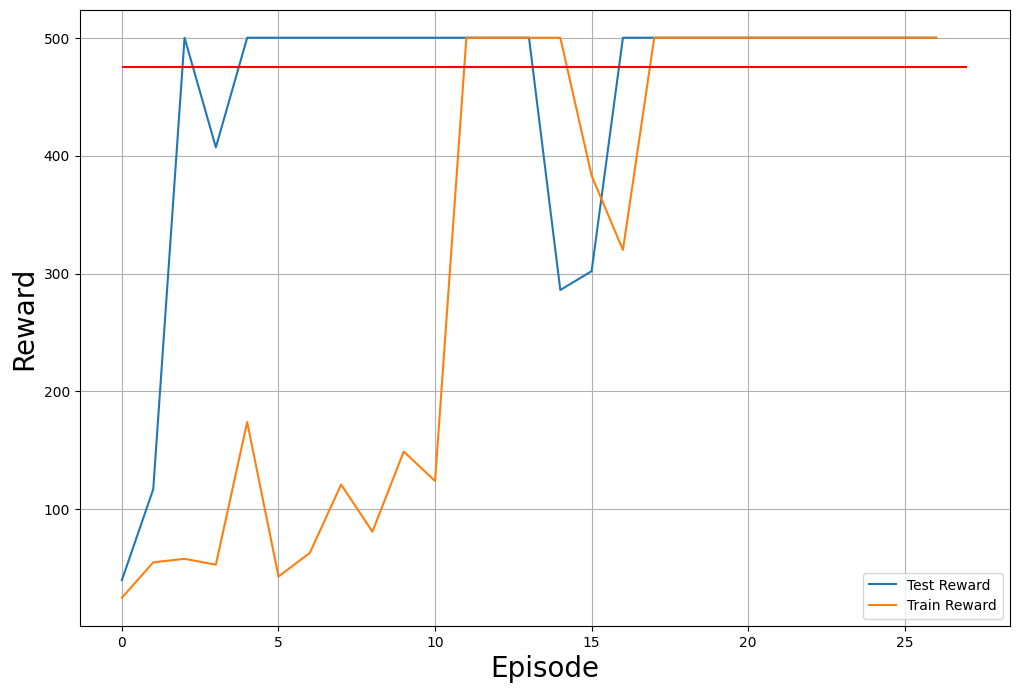

In [9]:
plot_reward(train_rewards, test_rewards, REWARD_THRES)